# Quantify organelle morphology - part 11.1
--------------------

## OVERVIEW
Now that all organelles and masks are segmented, we can begin to quantify features of organelle composition, morphology, contacts, and distribution. 


## OBJECTIVE: ✅ Quantify ***organelle*** composition and morphology
In this notebook, the logic for quantifying organelle composition (how much of each organelle is present) and morphology (individual size and shape) is outlined.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
import itertools

import parse

import napari

from skimage.measure import (regionprops, _regionprops)

from napari.utils.notebook_display import nbscreenshot

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                        export_inferred_organelle,
                                        import_inferred_organelle,
                                        export_tiff,
                                        list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_my_props_to_dict, _assert_uint16_labels)
from infer_subc.utils.stats_helpers import *

from infer_subc.organelles import * 

from infer_subc.constants import (TEST_IMG_N,
                                    NUC_CH ,
                                    LYSO_CH ,
                                    MITO_CH ,
                                    GOLGI_CH ,
                                    PEROX_CH ,
                                    ER_CH ,
                                    LD_CH ,
                                    RESIDUAL_CH ) 

import time
%load_ext autoreload
%autoreload 2

## Get and load image for quantification
Specifically, this will include the raw image and the outputs from segmentation.

In [40]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

raw_data_path = data_root_path / "raw"
im_type = ".czi"

raw_file_list = list_image_files(raw_data_path,im_type)
raw_img_name = raw_file_list[test_img_n]

# adding an additional list of image paths for the matching segmentation files
seg_data_path = data_root_path / "out"
seg_file_list = list_image_files(seg_data_path, "tiff")

# changing output directory for this notebook to a new folder called "quant"
out_data_path = data_root_path / "quant"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [41]:
# raw image
raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [42]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks
nuc_seg = import_inferred_organelle("20230426_test_nuc", raw_meta_dict, seg_data_path)
cell_seg = import_inferred_organelle("20230426_test_cell", raw_meta_dict, seg_data_path)
cyto_seg = import_inferred_organelle("20230426_test_cyto", raw_meta_dict, seg_data_path)
# mask_seg = import_inferred_organelle("masks", raw_meta_dict, seg_data_path)

#organelles
lyso_seg = import_inferred_organelle("20230426_test_lyso", raw_meta_dict, seg_data_path)
mito_seg = import_inferred_organelle("20230426_test_mito", raw_meta_dict, seg_data_path)
golgi_seg = import_inferred_organelle("20230426_test_golgi", raw_meta_dict, seg_data_path)
perox_seg = import_inferred_organelle("20230426_test_perox", raw_meta_dict, seg_data_path)
ER_seg = import_inferred_organelle("20230426_test_ER", raw_meta_dict, seg_data_path)
LD_seg = import_inferred_organelle("20230426_test_LD", raw_meta_dict, seg_data_path)


loaded  inferred 3D `20230426_test_nuc`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cell`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cyto`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_lyso`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_mito`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_golgi`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_perox`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_ER`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_LD`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 


-------------------------
## Visualize the image and segmentation outputs

In [5]:
viewer = napari.Viewer()

In [6]:
viewer.add_image(raw_img_data)

<Image layer 'raw_img_data' at 0x2ab01df88b0>

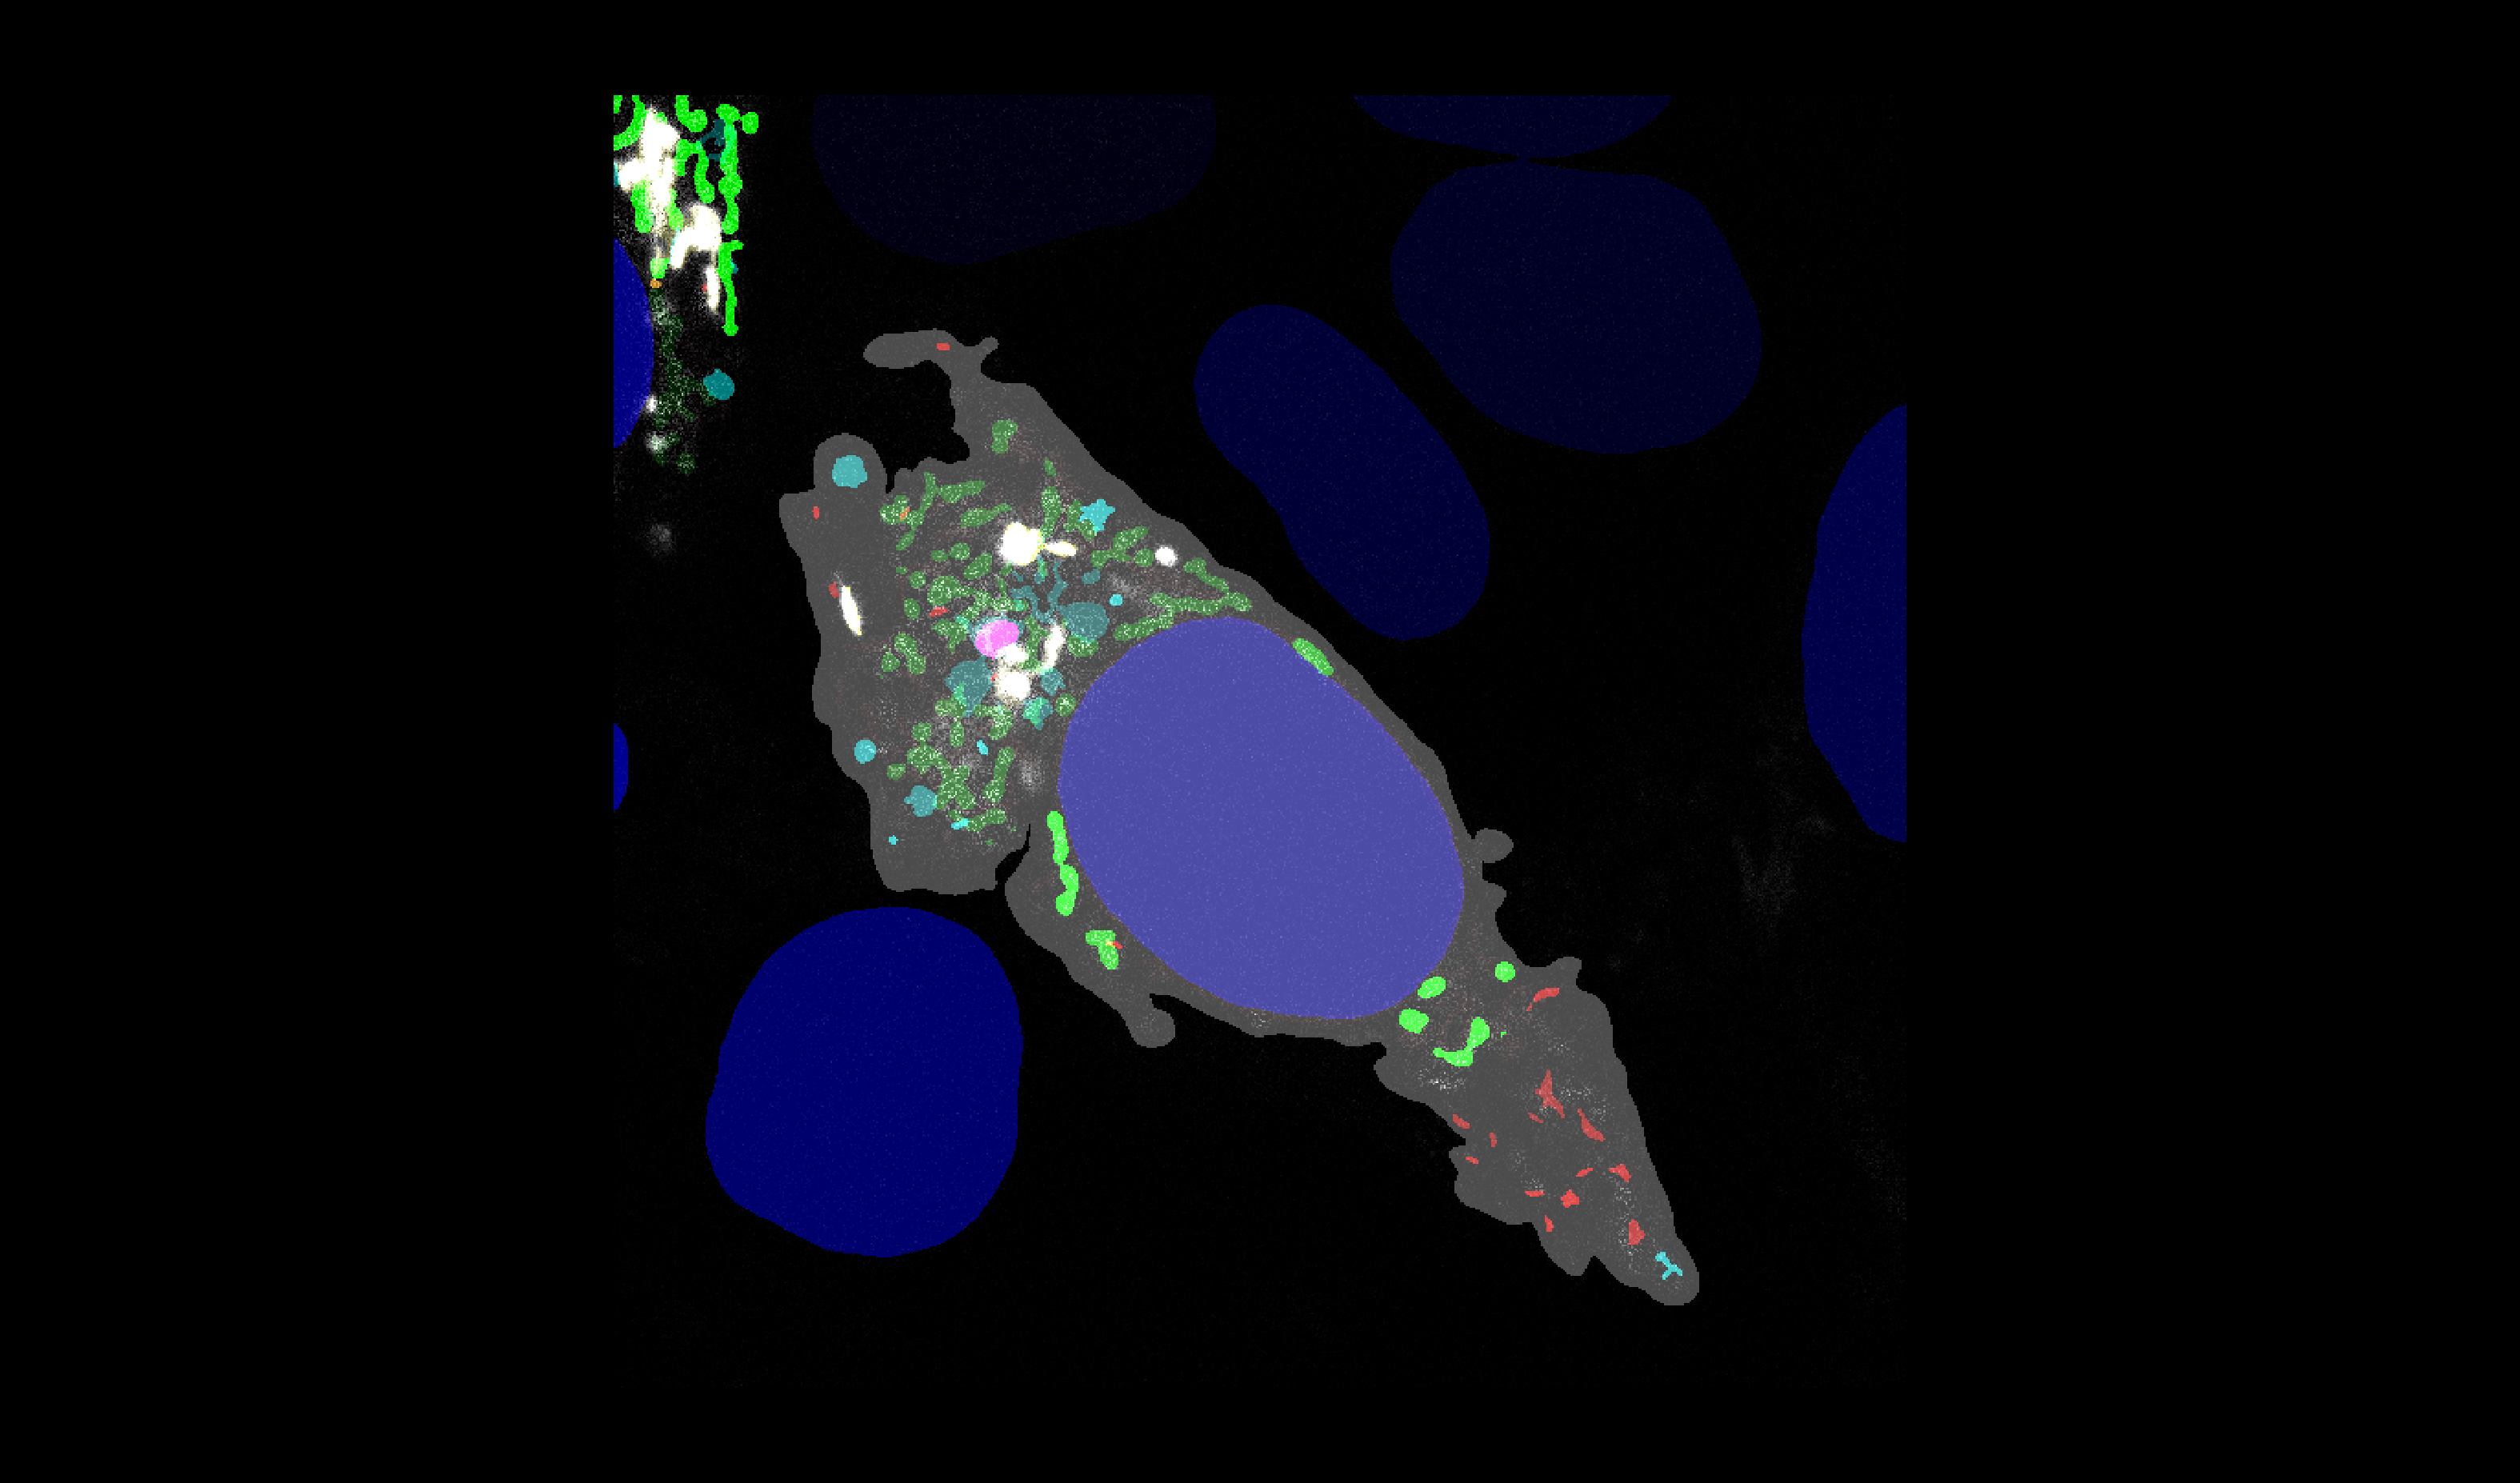

In [7]:
viewer.add_image(cell_seg, colormap='gray', opacity=0.3, blending ='additive')

viewer.add_image(nuc_seg, colormap='blue', blending ='additive')
viewer.add_image(lyso_seg, colormap='cyan', blending ='additive')
viewer.add_image(mito_seg, colormap='green', blending ='additive')
viewer.add_image(golgi_seg, colormap='yellow', blending ='additive')
viewer.add_image(perox_seg, colormap='bop orange', blending ='additive')
viewer.add_image(ER_seg, colormap='red', blending ='additive')
viewer.add_image(LD_seg, colormap='magenta', blending ='additive')

nbscreenshot(viewer, canvas_only=True)

In [8]:
viewer.close()

-------------------------
## Exploring the regionprops measurements

### Some regionprops measurements are not possible in 3D or with real world units:

> Below, we have listed the properties that are supported in 3D and the properties that support scaling to real-world units.
>
> NOTE: 
> The regionprop property names correspond to 2D measurements even for those that are able to function in 3D (i.e. "area" is actually "volume" when a 3D image is being processed, etc.).

In [9]:
labels = label(nuc_seg )
rp = regionprops(labels, intensity_image=raw_img_data[NUC_CH], spacing=scale)

supported = [] 
unsupported = []

for prop in rp[0]:
    try:
        rp[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties for 3D analysis:")
print("  " + "\n  ".join(supported))
print()
print("Properties only supported in 2D:")
print("  " + "\n  ".join(unsupported))

Supported properties for 3D analysis:
  area
  area_bbox
  area_convex
  area_filled
  axis_major_length
  axis_minor_length
  bbox
  centroid
  centroid_local
  centroid_weighted
  centroid_weighted_local
  coords
  equivalent_diameter_area
  euler_number
  extent
  feret_diameter_max
  image
  image_convex
  image_filled
  image_intensity
  inertia_tensor
  inertia_tensor_eigvals
  intensity_max
  intensity_mean
  intensity_min
  label
  moments
  moments_central
  moments_normalized
  moments_weighted
  moments_weighted_central
  moments_weighted_normalized
  slice
  solidity

Properties only supported in 2D:
  eccentricity
  moments_hu
  moments_weighted_hu
  orientation
  perimeter
  perimeter_crofton


Below, we have listed the properties that are scalable to real-world units (microns):

>>Scaled
>>- volume: n * zyx
>>- equivalent diameter: n * zyx**(1/3)
>>- centroid-0: n * z
>>- centroid-1: n * y
>>- centroid-2: n * x
>>- surface_area: depends on the shape

>>Not Scaled
>>- bbox (0-5) - `scale not necessary`
>>- euler_number - `scale not necessary`
>>- extent - `scale not necessary`
>>- max_intensity - `scale not necessary`
>>- mean_intensity - `scale not necessary`
>>- min_intensity - `scale not necessary`
>>- standard_deviation_intensity - `scale not necessary`

-------------------------
## **ORGANELLE METRICS**

To measure the amount, size, and shape of the individual organelles, we will utilize `skimage.measure.regionprops`. These measurements can be collected based on pixel/voxel units (assuming the image is isotropic in all dimensions) and or "real-world" units. Since most confocal microscope images are anisotropic (mostly with respect to the Z dimension), we will preferentially utilize real-world units. Luckily, regionprops>=0.20.0 has incorporated a spacing parameter that can handle anisotropic data.

Similar concepts will also be applied to measure the cell, cytoplasm, and nucleus below as well as organelle contacts in notebook {???}.

### 0. Apply cell mask
To ensure we are performing single cell analysis, we will apply the cell segmentation as a mask.

In [10]:
nuc_masked = apply_mask(nuc_seg, cell_seg)

### 1. Build the list of measurements we want to include from regionprops

In [11]:
# start with LABEL
test_properties = ["label"]

# add position
test_properties = test_properties + ["centroid", "bbox"]

# add area
test_properties = test_properties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements
test_properties = test_properties + ["extent", "euler_number", "solidity", "axis_major_length"] # "feret_diameter_max", "axis_minor_length"]

# add intensity values (used for quality checks only)
test_properties = test_properties + ["min_intensity", "max_intensity", "mean_intensity"]

test_properties

['label',
 'centroid',
 'bbox',
 'area',
 'equivalent_diameter',
 'extent',
 'euler_number',
 'convex_area',
 'solidity',
 'axis_major_length',
 'min_intensity',
 'max_intensity',
 'mean_intensity']

### 2. Add additional measurements as "extra_properties" with custom functions.

In [12]:
# create a function to include the standard deviation of intensities (for quality checks only)
def _standard_deviation_intensity(region, intensities):
    return np.std(intensities[region])

test_extra_properties = [_standard_deviation_intensity]

### 3. Run regionprops and export values as a pandas dataframe

In [13]:
test_rp = regionprops(label_image=nuc_masked,
                      intensity_image=raw_img_data[0], 
                      extra_properties=test_extra_properties, 
                      spacing=scale)

In [14]:
test_props = _my_props_to_dict(test_rp, 
                               label_image=nuc_masked, 
                               intensity_image=raw_img_data[0], 
                               properties=test_properties, 
                               extra_properties=test_extra_properties,
                               spacing=scale)

`TO DO: figure out if regionprops_table() function from skimage.measure._regionprops can just be used instead of the combination of the two function above.`

In [15]:
test_props_table = pd.DataFrame(test_props)

test_props_table.rename(columns={"area": "volume"}, inplace=True)

round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
test_props_table.insert(loc=1, column="scale", value=f"{round_scale}")

### 4. Add additional measurements

In [16]:
# creating a function to measure the surface area of each object. This function utilizes "marching_cubes" to generate a mesh (non-pixelated object)
def _surface_area_from_props(labels: np.ndarray,
                             props: dict,
                             spacing: Union[tuple, None]=None):
    """ 
    a function for getting surface area of volumetric objects

    Parameters:
    ----------
    lables:
        the segmentation np.ndarray with each object labeled a different number
    props:
        region props dictionary resulting from the _my_props_to_dict() function
    spacing:
        tuple of the dimension lengths in the same order as the dimension of your np.ndarray labels input
    """
    
    if spacing is None:
        spacing = np.ones(labels.ndim)

    surface_areas = np.zeros(len(props["label"]))

    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[
            max(props["bbox-0"][index] - 1, 0) : min(props["bbox-3"][index] + 1, labels.shape[0]),
            max(props["bbox-1"][index] - 1, 0) : min(props["bbox-4"][index] + 1, labels.shape[1]),
            max(props["bbox-2"][index] - 1, 0) : min(props["bbox-5"][index] + 1, labels.shape[2]),
        ]
        volume = volume == lab
        verts, faces, _normals, _values = marching_cubes(volume,
                                                         method="lewiner",
                                                         spacing=spacing,
                                                         level=0)
        
        surface_areas[index] = mesh_surface_area(verts, faces)

    return surface_areas

In [76]:
# props["surface_area"] = surface_area_from_props(nuc_seg, props)
test_surface_area_tab = pd.DataFrame(_surface_area_from_props(nuc_masked, test_props, scale))

test_props_table.insert(11, "surface_area", test_surface_area_tab)
test_props_table.insert(13, "SA_to_volume_raiot", test_props_table["surface_area"].div(test_props_table["volume"]))

test_org_name = "nuc"
test_props_table.insert(1, "object", test_org_name)

In [77]:
pd.set_option('display.max_columns', None)

test_props_table

,label,object,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_raiot,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,_standard_deviation_intensity
0,5,nuc,"(0.3891, 0.0799, 0.0799)",2.628936,31.602057,28.150081,0,284,242,16,504,463,650.256734,1037.508176,0.626749,12.560231,0.537266,1,1135.780394,0.913476,21.135161,0.0,8392.0,2012.255031,1048.054565


### Define `get_org_morphology_3D()` function

Based on the _prototyping_ above define the function to quantify amount, size, and shape of organelles.

In [86]:
def _get_org_morphology_3D(segmentation_img: np.ndarray, seg_name: str, intensity_img, mask: np.ndarray, scale: Union[tuple, None]=None) -> Tuple[Any, Any]:
    """
    Parameters
    ------------
    segmentation_img:
        a 3d np.ndarray image of the segemented organelles
    intensity_img:
        a 3d np.ndarray image of the "raw" florescence intensity the segmentation was based on
    mask:
        a 3d np.ndarray image of the cell mask (or other mask of choice); used to create a "single cell" analysis

    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each object in the segmentation image (rows) and the regionprops object

    Regionprops measurements included:
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length',
    'max_intensity',
    'mean_intensity',
    'min_intensity']

    Additional measurement include:
    ['standard_deviation_intensity',
    'surface_area']
    """
    ###################################################
    ## MASK THE ORGANELLE OBJECTS THAT WILL BE MEASURED
    ###################################################
    # in case we sent a boolean mask (e.g. cyto, nucleus, cellmask)
    input_labels = _assert_uint16_labels(segmentation_img)

    # mask
    input_labels = apply_mask(input_labels, mask)

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties = properties + ["centroid", "bbox"]

    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements
    properties = properties + ["extent", "euler_number", "solidity", "axis_major_length", "axis_minor_length"] # ,"feret_diameter_max"]

    # add intensity values (used for quality checks)
    properties = properties + ["min_intensity", "max_intensity", "mean_intensity"]

    #######################
    ## ADD EXTRA PROPERTIES
    #######################
    def standard_deviation_intensity(region, intensities):
        return np.std(intensities[region])

    extra_properties = [standard_deviation_intensity]

    ##################
    ## RUN REGIONPROPS
    ##################
    rp = regionprops(input_labels, 
                     intensity_image=intensity_img, 
                     extra_properties=extra_properties, 
                     spacing=scale)

    props = _my_props_to_dict(rp, 
                              label_image=input_labels, 
                              intensity_image=intensity_img, 
                              properties=properties, 
                              extra_properties=extra_properties,
                              spacing=scale)

    props_table = pd.DataFrame(props)
    props_table.rename(columns={"area": "volume"}, inplace=True)
    props_table.insert(0, "object", seg_name)

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=2, column="scale", value=f"{round_scale}")
    else: 
        props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(segmentation_img.ndim))}") 

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(_surface_area_from_props(input_labels, props, scale))

    props_table.insert(11, "surface_area", surface_area_tab)
    props_table.insert(13, "SA_to_volume_raiot", props_table["surface_area"].div(props_table["volume"]))

    ################################################################
    ## ADD SKELETONIZATION OPTION FOR MEASURING LENGTH AND BRANCHING
    ################################################################
    #  # ETC.  skeletonize via cellprofiler /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/morphologicalskeleton.py
    #         if x.volumetric:
    #             y_data = skimage.morphology.skeletonize_3d(x_data)
    # /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/measureobjectskeleton.py

    return props_table, rp

In [87]:
org_img = raw_img_data[0]
seg_name = 'nuc'
org_obj = nuc_seg
cell_mask = cell_seg

# with scale
nuc_table, rp = _get_org_morphology_3D(segmentation_img=org_obj, seg_name=seg_name, intensity_img=org_img, mask=cell_mask, scale=scale)
nuc_table

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,surface_area,bbox-5,SA_to_volume_raiot,volume,equivalent_diameter,extent,euler_number,solidity,axis_major_length,axis_minor_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,nuc,5,"(0.3891, 0.0799, 0.0799)",2.628936,31.602057,28.150081,0,284,242,16,504,650.256734,463,0.626749,1037.508176,12.560231,0.537266,1,0.913476,21.135161,6.502207,0.0,8392.0,2012.255031,1048.054565


In [88]:
# without scale
nuc_table_unscaled, rp_unsc = _get_org_morphology_3D(segmentation_img=org_obj, seg_name=seg_name, intensity_img=org_img, mask=cell_mask)
nuc_table_unscaled

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,surface_area,bbox-5,SA_to_volume_raiot,volume,equivalent_diameter,extent,euler_number,solidity,axis_major_length,axis_minor_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,nuc,5,"(1.0, 1.0, 1.0)",6.756134,395.660493,352.44145,0,284,242,16,504,64248.140625,463,0.153722,417950.0,92.763096,0.537266,1,0.913476,264.582839,16.72367,0.0,8392.0,2012.255031,1048.054565


In [25]:
# Will result in FALSE because the _standard_deviation_intensity function was used in the prototyping 
# instead of the standard_deviation_intensity function from stats.py
nuc_table.equals(test_props_table)

False

### Add prototype function into `stats.py`

In [27]:
from infer_subc.utils.stats import get_org_morphology_3D

nuc_table_final, rp = get_org_morphology_3D(org_obj, org_img, cell_mask, scale=scale)

In [28]:
nuc_table.equals(nuc_table_final)

True